In [ ]:
from IPython import get_ipython
# """ 
# Case02_LogRegClf_v1: 
# At time of arrival, Combined output features. 
# RandomOverSample method.

# Report final model:
#     Accuracy  = 0.626
#     Precision = 0.674
# """ 


   ---


 # <span style="color:MediumSlateBlue"> Case 02</span>

 <span style="color:MediumSlateBlue">**02582 Computational Data Analysis Spring 21**</span>

 <span style="color:MediumSlateBlue">**April 2021**</span>

 <span style="color:MediumSlateBlue"> **Data-set Reference: Myocardial infarction complications Data Set<sup>[link](https://archive.ics.uci.edu/ml/datasets/Myocardial+infarction+complications)</sup>**

   ---



  ---

   # <span style="color:MediumSlateBlue"> Import needed libraries and set seed: </span>

  ---
  

In [ ]:
""" set seed (for reproducibility)"""
seed = 1992

""" for data handling """
import numpy as np
import pandas as pd

""" for Display """
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas import set_option

""" for data preprocessing """
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler

""" for model selection """ 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

""" for Reporting metrics """
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

""" for models """
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
get_ipython().system('pip install imbalanced-learn')
from imblearn.pipeline import Pipeline

""" for warnings """
import warnings 
warnings.simplefilter("ignore")


  ---

   # <span style="color:MediumSlateBlue"> Load problem-data:: </span>

  ---

Input features:
- At time of arrival. 
- All columns 2-112 except 93, 94, 95, 100, 101, 102, 103, 104, 105;

Output feature:
- Binary Combined of all output features but not Lethal outcome (124), 113-123:
    - If any output feature shows 1 then 1.
    - else 0.

In [ ]:
""" load whole data """ 
filename = 'MI.data'
Data = pd.read_csv(filename, header=None, na_values='?', names=[str(i) for i in range(1,125,1)])

""" Input features (At time of arrival) """
drop_columns = [93, 94, 95, 100, 101, 102, 103, 104, 105]  # At time of arrival
data_input = Data[[str(i) for i in range(2,113,1)]].drop(columns = [str(i) for i in drop_columns]).copy()

""" Output features """
data_out = Data[[str(i) for i in range(113,124,1)]].copy()    
data_out['125'] = np.where(data_out.sum(axis=1) == 0, 0, 1)  # Respone Combined output features (125)
data_out = data_out['125']

""" Concatenate output + input  """
data = pd.concat([data_out, data_input], axis=1).copy()

""" Free memory """
del (data_input, data_out, Data)


  ---

  # <span style="color:MediumSlateBlue"> Getting to know the data: </span>

  ---


In [ ]:
""" head """
data.head(5)

,125,2,3,4,5,6,7,8,9,10,...,97,98,99,106,107,108,109,110,111,112
0,0,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,...,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
""" shape """
data.shape

(1700, 103)

In [ ]:
""" info """
data.info(max_cols=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Columns: 103 entries, 125 to 112
dtypes: float64(101), int32(1), int64(1)
memory usage: 1.3 MB


In [ ]:
""" descriptions """
pd.set_option('precision', 2)
data.describe()

,125,2,3,4,5,6,7,8,9,10,...,97,98,99,106,107,108,109,110,111,112
count,1700.00,1692.00,1700.00,1696.00,1594.00,1627.00,1649.00,72.00,1691.00,1692.00,...,1014.00,1023.00,1691.00,1690.00,1689.00,1687.00,1683.00,1683.00,1684.00,1684.0
mean,0.55,61.86,0.63,0.55,2.32,1.21,1.16,0.38,1.39,0.03,...,0.69,0.39,0.12,0.28,0.13,0.67,0.71,0.74,0.02,0.2
std,0.50,11.26,0.48,0.84,2.44,1.04,0.80,0.49,1.09,0.18,...,0.46,0.49,0.32,0.45,0.33,0.47,0.45,0.44,0.13,0.4
min,0.00,26.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,0.00,54.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
50%,1.00,63.00,1.00,0.00,1.00,2.00,1.00,0.00,2.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.0
75%,1.00,70.00,1.00,1.00,5.00,2.00,2.00,1.00,2.00,0.00,...,1.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.0
max,1.00,92.00,1.00,3.00,6.00,4.00,2.00,1.00,3.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


In [ ]:
""" check for class balanced """
data['125'].value_counts()

1    935
0    765
Name: 125, dtype: int64


  ---

  # <span style="color:MediumSlateBlue"> Data preparation: </span>

  ---



  ---
  ## Messing data:
  ---

 Drop features that have more that 25% messing values


In [ ]:
""" Drop features that have more that 25% messing values """
null_percentage = (data.isnull().sum(axis = 0)/data.shape[0]).values
drop_cols = data.columns[(null_percentage > 0.25)].values
data = data.drop(columns = drop_cols)
print(f'Number of dropped features {len(drop_cols)}')
print(f'The dropped features are : {drop_cols}')


Number of dropped features 7
The dropped features are : ['8' '35' '36' '89' '96' '97' '98']



  ---
  ## Explore features-types:
  ---

 The idea here, is to have three features types:
 - Continues features.
 - Categorical features with more than 4 classes.
 - Categorical features with 4 or less classes.

These types can be used later in Data-preprocessor as the following:
 - Impute missing values:
   - As mean for Continues features.
   - As mode for categorical features.
 - Encode features:
   - onehotencode, for categorical with 4 or less classes.



In [ ]:
""" Continues features """
cont=[]
for i in data.columns:
    if not(np.array_equal(data[i].fillna(0), data[i].fillna(0).astype(int))):
        cont.append(i)
        # print(f'column {i} is continuos, with the unique values:')
        # print(data[i].unique())
        # print()
print(f'{len(cont)} Continues features.')
print(f'They are:\n{cont}\n')

4 Continues features.
They are:
['84', '87', '88', '90']



In [ ]:
""" categorical features with more than 4 classes """
cat_long=[]
for i in data.columns:
    if (np.array_equal(data[i].fillna(0), data[i].fillna(0).astype(int))) and (len(data[i].unique()) > 4):
        cat_long.append(i)
        # print(f'column {i} is long cat, with the unique values:')
        # print(data[i].unique())
        # print()
print(f'{len(cat_long)} Categorical features with more than 4 classes.')
print(f'They are:\n{cat_long}\n')

16 Categorical features with more than 4 classes.
They are:
['2', '4', '5', '6', '9', '11', '12', '37', '38', '45', '46', '47', '48', '86', '91', '92']



In [ ]:
""" categorical features with 4 or less classes """
cat_short = [i for i in data.columns if ( (not(i in cat_long)) & (not(i in cont)) ) ]
print(f'{len(cat_short)} Categorical features with 4 or less classes.')
print(f'They are:\n{cat_short}\n')

76 Categorical features with 4 or less classes.
They are:
['125', '3', '7', '10', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '39', '40', '41', '42', '43', '44', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '85', '99', '106', '107', '108', '109', '110', '111', '112']




  ---
  ## Define Features-preprocessor:
  ---

 - To be used in each CV fold


In [ ]:
""" Continues features (cont) """
numeric_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('stand', StandardScaler())
        ])

""" Long categorical features, with more than 4 classes (cat_long) """
categorical_long_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('stand', StandardScaler())
        ])

""" Short categorical features, with 4 or less classes (cat_short) """
categorical_short_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown= 'ignore', sparse=False)),
        ('stand', StandardScaler())
        ])

In [ ]:
""" Features-preprocessor """
preprocessor = ColumnTransformer(
        transformers=[
        ('cont', numeric_transformer, cont),
        ('cat_long', categorical_long_transformer, cat_long),
        ('cat_short', categorical_short_transformer, cat_short)  
        ])


  ---
  ## Class Balance:
  ---

- To be used in each CV fold

Here we will use the **Random Oversampling** method.

  The method randomly duplicates samples from the minority class in the training dataset and can result in overfitting for some models
  (See [link](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)).


In [ ]:
""" Data-oversampler"""
over_sampler = RandomOverSampler(random_state=seed)


  ---

  # <span style="color:MediumSlateBlue"> Data Exploration: </span>

  ---


In [ ]:
""" head """
data.head(5)

,125,2,3,4,5,6,7,9,10,11,...,91,92,99,106,107,108,109,110,111,112
0,0,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,...,16.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,...,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,...,NaN,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,...,NaN,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
""" shape """
data.shape

(1700, 96)

In [ ]:
""" info """
data.info(max_cols=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Columns: 96 entries, 125 to 112
dtypes: float64(94), int32(1), int64(1)
memory usage: 1.2 MB


In [ ]:
""" descriptions continues features """
pd.set_option('precision', 2)
data[cont].describe()       # cont

,84,87,88,90
count,1329.00,1416.00,1415.00,1575.00
mean,4.19,0.48,0.26,8.78
std,0.75,0.39,0.20,3.40
min,2.30,0.03,0.04,2.00
25%,3.70,0.23,0.15,6.40
50%,4.10,0.38,0.22,8.00
75%,4.60,0.61,0.33,10.45
max,8.20,3.00,2.15,27.90


In [ ]:
""" descriptions long Categorical features """
pd.set_option('precision', 2)
data[cat_long].describe()   # cat_long 

,2,4,5,6,9,11,12,37,38,45,46,47,48,86,91,92
count,1692.00,1696.00,1594.00,1627.00,1691.00,1452.00,1646.00,1433.00,1433.00,1617.00,1620.00,1620.00,1628.00,1325.00,1497.00,1574.00
mean,61.86,0.55,2.32,1.21,1.39,3.34,0.19,134.59,82.75,1.57,0.86,1.01,0.26,136.55,13.44,4.68
std,11.26,0.84,2.44,1.04,1.09,3.10,0.66,31.35,18.32,1.71,0.88,1.40,0.70,6.51,11.30,2.87
min,26.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,117.00,1.00,1.00
25%,54.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,80.00,0.00,0.00,0.00,0.00,133.00,5.00,2.00
50%,63.00,0.00,1.00,2.00,2.00,3.00,0.00,130.00,80.00,1.00,1.00,0.00,0.00,136.00,10.00,4.00
75%,70.00,1.00,5.00,2.00,2.00,7.00,0.00,150.00,90.00,4.00,1.00,2.00,0.00,140.00,18.00,7.00
max,92.00,3.00,6.00,4.00,3.00,7.00,4.00,260.00,190.00,4.00,4.00,4.00,4.00,169.00,140.00,9.00


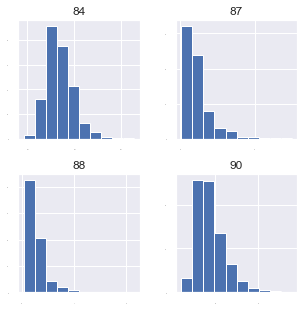

In [ ]:
""" histograms continues features """
data[cont].hist(
                sharex=False,
                sharey=False, 
                xlabelsize=1, 
                ylabelsize=1, 
                figsize=(5,5));

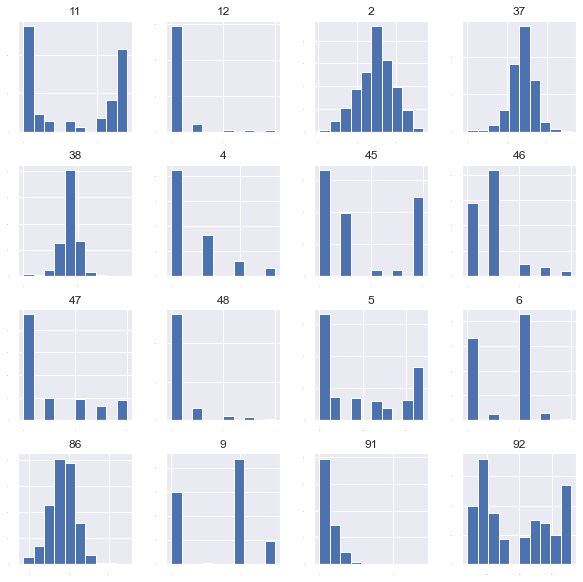

In [ ]:
""" histograms long Categorical features"""
data[cat_long].hist(
                sharex=False,
                sharey=False, 
                xlabelsize=1, 
                ylabelsize=1, 
                figsize=(10,10));


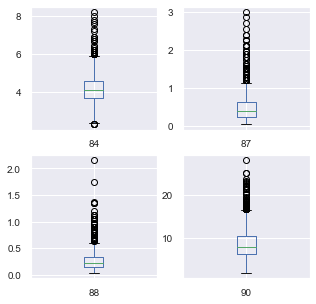

In [ ]:
""" Box and whisker plots continues features"""
data[cont].plot(
                kind='box', 
                sharex=False, 
                sharey=False, 
                fontsize=10, 
                subplots=True, 
                layout=(2,2), 
                figsize=(5,5));

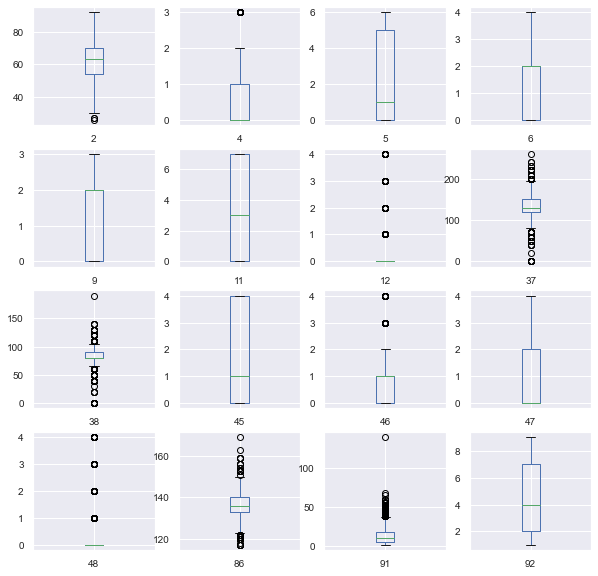

In [ ]:
""" Box and whisker plots long Categorical features"""
data[cat_long].plot(
                kind='box', 
                sharex=False, 
                sharey=False, 
                fontsize=10, 
                subplots=True, 
                layout=(4,4), 
                figsize=(10,10));

In [ ]:
""" correlation """
cor_matrix_boolean = abs(data.astype('float64').corr(method='pearson')) > 0.5
cols = cor_matrix_boolean.columns.values
cor_cols = []
cor_index = []
for i in range (cor_matrix_boolean.shape[0]):
    for j in range (cor_matrix_boolean.shape[0]):
        if (i==j):
            continue
        else:
            if cor_matrix_boolean.iloc[i,j]:
                if ((cols[i],cols[j]) in cor_cols) | ((cols[j],cols[i]) in cor_cols):
                    continue
                else: 
                    cor_cols.append((cols[i],cols[j]))
                    cor_index.append((i,j))
print('The following features has |Correlation| > 0.5:')
print(cor_cols)

for (i,j) in cor_index:
   cor_val = data.iloc[:,i].corr(data.iloc[:,j])
   if (cor_val > 0.75):
    print(f'{i,j} with cor(col_{i},col_{j}) = {data.iloc[:,i].corr(data.iloc[:,j])}') 


The following features has |Correlation| > 0.5:
[('5', '6'), ('9', '11'), ('17', '51'), ('17', '61'), ('37', '38'), ('38', '40'), ('41', '51'), ('41', '60'), ('42', '62'), ('45', '46'), ('45', '47'), ('50', '54'), ('51', '60'), ('51', '61'), ('52', '69'), ('83', '84'), ('87', '88')]
(4, 5) with cor(col_4,col_5) = 0.7630190221557122
(7, 9) with cor(col_7,col_9) = 0.7758654040495621
(33, 34) with cor(col_33,col_34) = 0.8612659405801627
(37, 47) with cor(col_37,col_47) = 0.8456950630339494


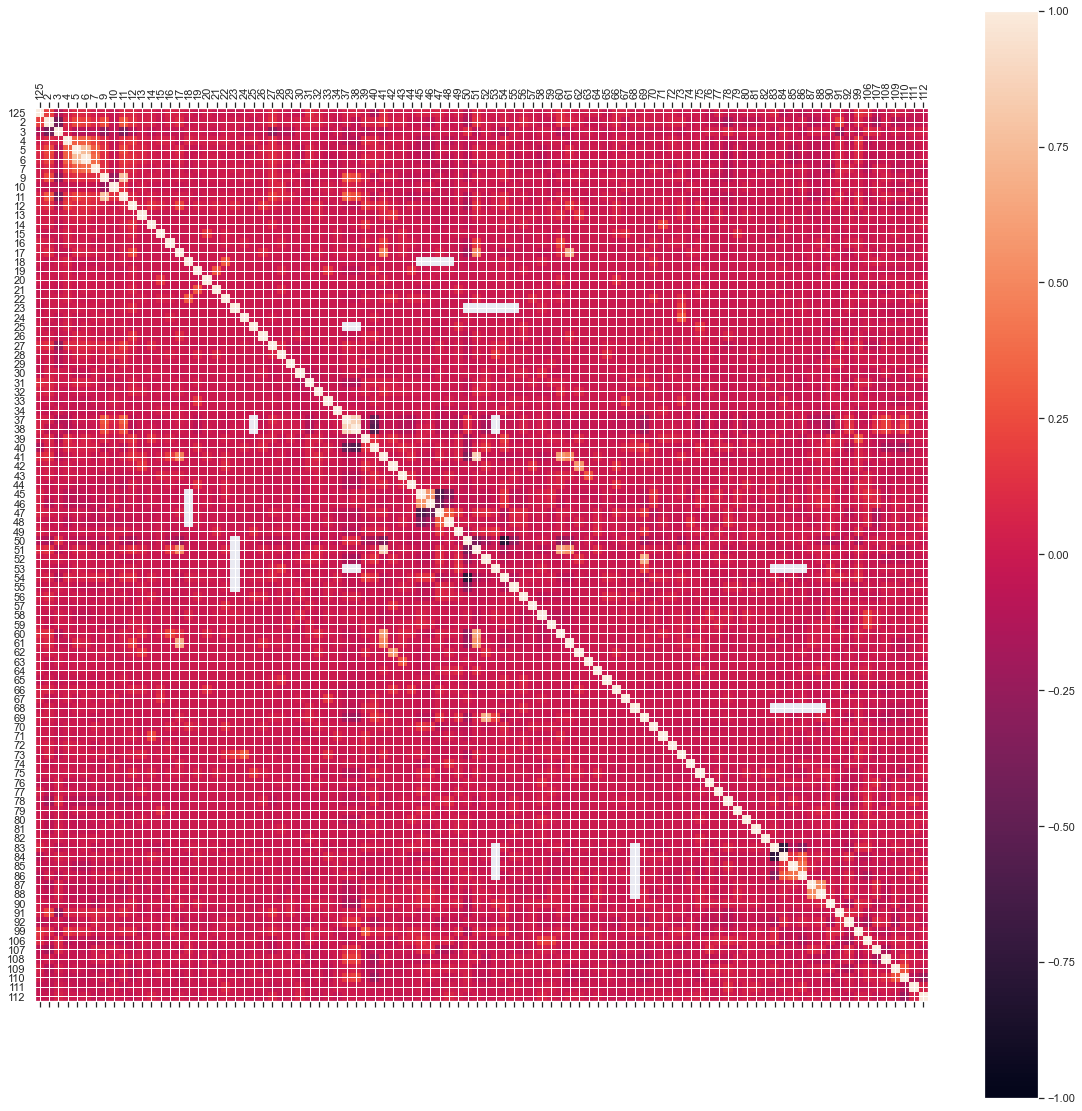

In [ ]:
""" correlation matrix plot """
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(data.astype('float64').corr(method='pearson'), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns,rotation=90)
ax.set_yticklabels(data.columns)
plt.show()


  ---

  # <span style="color:MediumSlateBlue"> Split data for learning: </span>

  ---


In [ ]:
""" Split-out X,Y datasets """
X = data.iloc[:,1:]
Y = data.iloc[:,0]
cat_short.remove('125') # We need to drop the Y from the input space totally. 

""" Split-out validation dataset in a stratified way """
validation_size = 0.20
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, stratify=Y, random_state=seed)



  ---

  # <span style="color:MediumSlateBlue"> Spot-Check Algorithms: </span>

  ---

  Spot-Check Algorithms:
  - Logistic Regression classifier: LogisticRegression().
  - Linear Discriminant Analysis: LinearDiscriminantAnalysis()
  - k-nearest neighbors classifier: KNeighborsClassifier().
  - Decision tree classifier: DecisionTreeClassifier().
  - Naive Bayes: GaussianNB().
  - Support Vector Classification: SVC().

In [ ]:
""" models """
pipelines = []
pipelines.append(('LR', Pipeline([('over_sampler', over_sampler),('preprocessor', preprocessor),('lr',LogisticRegression())])))
pipelines.append(('LDA', Pipeline([('over_sampler', over_sampler),('preprocessor', preprocessor),('lda',LinearDiscriminantAnalysis())])))
pipelines.append(('KNN', Pipeline([('over_sampler', over_sampler),('preprocessor', preprocessor),('knn',KNeighborsClassifier())])))
pipelines.append(('NB', Pipeline([('over_sampler', over_sampler),('preprocessor', preprocessor),('nb',GaussianNB())])))
pipelines.append(('SVM', Pipeline([('over_sampler', over_sampler),('preprocessor', preprocessor),('svm',SVC())])))
pipelines.append(('CART', Pipeline([('over_sampler', over_sampler),('preprocessor', preprocessor),('cart',DecisionTreeClassifier())])))

**Evaluation metric (precision):**   

Since we have an imbalanced classification problem.  
Accuracy can be dangerously misleading.   
Thus, precision will be used as an evaluation metric.   

It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted:  

$$\frac{TruePositive}{(TruePositive + FalsePositive)}$$  

Which means it calculates the accuracy for the minority class.

In [ ]:
scoring = 'precision' 

In [ ]:
""" CV """
results = []
names = []
for name, model in pipelines:
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=skfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.671510 (0.025113)
LDA: 0.676993 (0.026719)
KNN: 0.673968 (0.034759)
NB: 0.700815 (0.082198)
SVM: 0.669400 (0.028030)
CART: 0.601288 (0.026145)


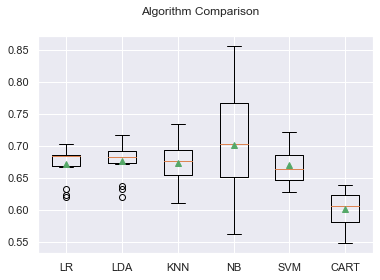

In [ ]:
""" Compare Algorithms """
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
plt.show()

 From the box-plot above it's seen that four models can be investgated further
 - Linear Discriminant Analysis.
 - KNN
 - Logistic Regression classifier
 - Note! Naive Bayes might be the best after tuning.


  ---

  # <span style="color:MediumSlateBlue"> Tuning Logistic Regression classifier: </span>

  ---

- **Regularization method**, the norm used in the penalization (penalty in sklearn).
- **Inverse of Regularization strength**, must be a positive float, smaller values specify stronger regularization (C in sklearn).
- **Optimization problem algorithm** (solver in sklearn ):
    - since we have lots of features due to onehotencoding short categorical features l2 norm method and solver won't be included.
    - ‘liblinear’ and ‘saga’ handle L1 penalty
    - ‘elasticnet’ is only supported by the ‘saga’ solve
    - Treat! For small datasets, ‘liblinear’ is a good choice, whereas ‘saga’ are faster for large ones
- For the full list of hyperparameters, (See [link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). 


  ---
  ## Abstract Tuning :
  ---
5 X 3 CV  

20 different hyper-parmeters combenations in each inner cv fold  
Totalling in 300 fits

Maximum Number of features 245 = len(cat_short) \* 3 + len(cont) + len(cat_long) 

In [ ]:
""" Define models and parameters """
model = Pipeline([ 
            ('over_sampler', over_sampler),
            ('preprocessor', preprocessor), 
            ('lr',LogisticRegression()) 
            ]) 

""" Define grid parameters """
solvers = ['liblinear', 'saga']          # Algorithm to use in the optimization problem.
penalty = ['l1', 'elasticnet']           # Regularization method; The norm used in the penalization
c_values = [100, 10, 1.0, 0.1, 0.01]     # Inverse of regularization strength; must be a positive float. smaller values specify stronger regularization.
grid = dict(lr__solver=solvers, lr__penalty=penalty, lr__C=c_values)

""" Define grid search """
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring=scoring, cv=cv, n_jobs=-1,verbose = 2)
grid_result = grid_search.fit(X, Y)

""" best results """
print("Best Precision: %f (%f) \nUsing %s" % (grid_result.best_score_, grid_result.cv_results_['std_test_score'][grid_result.best_index_], grid_result.best_params_))

""" CV results """
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Best Precision: 0.693629 (0.024221) 
Using {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


' CV results '


  ---
  ## Focused Tuning :
  ---

 Around The founded best hyper-parameters combenation.


In [ ]:
""" Define models and parameters """
model = Pipeline([ 
            ('over_sampler', over_sampler),
            ('preprocessor', preprocessor), 
            ('lr',LogisticRegression()) 
            ]) 

""" Define grid parameters """
solvers = ['liblinear']                  # Founded optimization Algorithm.
penalty = ['l1']                         # Founded Regularization method
c_values = [0.5, 0.2, 0.1, 0.05, 0.01]   # Around the founded Inverse of regularization strength



grid = dict(lr__solver=solvers, lr__penalty=penalty, lr__C=c_values)

""" Define grid search """
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring=scoring, cv=cv, n_jobs=-1,verbose = 2)
grid_result = grid_search.fit(X, Y)

""" best results """
print("Best Precision: %f (%f) \nUsing %s" % (grid_result.best_score_, grid_result.cv_results_['std_test_score'][grid_result.best_index_], grid_result.best_params_))
print()

""" CV results """
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 15 folds for each of 5 candidates, totalling 75 fits
Best Precision: 0.697559 (0.020863) 
Using {'lr__C': 0.05, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

0.687464 (0.021334) with: {'lr__C': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.690064 (0.022476) with: {'lr__C': 0.2, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.693629 (0.024221) with: {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.697559 (0.020863) with: {'lr__C': 0.05, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.634165 (0.021329) with: {'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}



  ---

  # <span style="color:MediumSlateBlue">  Prepare Final Model: </span>

  ---


In [ ]:
model = Pipeline([ 
            ('over_sampler', over_sampler),
            ('preprocessor', preprocessor), 
            ('lr',LogisticRegression(penalty= 'l1', C= 0.05, solver='liblinear')) 
            ]) 
model.fit(X_train, Y_train);



  ---

  # <span style="color:MediumSlateBlue">   Report: </span>

  ---
On validation(unseen) data.

In [ ]:
""" classification report """
predictions = model.predict(X_validation)
print('Accuracy= %.3f' % accuracy_score(Y_validation, predictions))
print('Precision: %.3f' % precision_score(Y_validation, predictions, average='binary'))
print('\nClassification Report:\n',classification_report(Y_validation, predictions))
"""
>
    Accuracy= 0.626
    Precision: 0.674
"""



Accuracy= 0.626
Precision: 0.674

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.63      0.60       153
           1       0.67      0.62      0.65       187

    accuracy                           0.63       340
   macro avg       0.63      0.63      0.63       340
weighted avg       0.63      0.63      0.63       340



'\n>\n    Accuracy= 0.626\n    Precision: 0.674\n'

<Figure size 432x288 with 0 Axes>

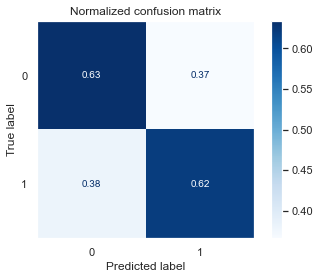

In [ ]:
""" confusion matrix """
plt.figure()
disp = plot_confusion_matrix(model, X_validation, Y_validation, cmap=plt.cm.Blues, normalize='true', include_values= True)  
disp.ax_.set_title('Normalized confusion matrix')
plt.grid(False)
plt.show()


  ---

  # <span style="color:MediumSlateBlue"> Theory and Notes: </span>

  ---
## Logistic Regression Notes:
1. **Logistic Regression**
    - Linear decision boundary
    - Fewer assumptions than LDA
    - Coefficients can be interpreted
    - Regularized versions

1. **Why Logistic Regression?**
    - Statistics:
        Identify variables important for separating the classes
    - Classification:
        Predict class belonging of new observations
    - Risk prediction: 
        Estimate probability (risk) of each class

1. ** Some Properties of Logistic Regression Some Properties of Logistic Regression: **
    - Logistic regression is more robust than LDA
    - Logistic regression handles categorical variables better than LDA
    - Observations far away from the boundary are down-weighted
    - Breaks down when classes are perfectly separable
    - Easy to interpret and explain
    - Surprisingly often hard to beat
    - Can be combined with regularization of parameters (n < p)
    - Can be generalized to multi-class problems

1. **Regularizations:**  
Few observations (low n) and high dimension (high p) data is a problem also for logistic regression. One solution is an elastic net regularization of the likelihood.

1. **Outliers**  
    Logistic regression focuses on observations close to the boundary. Thus, They are handled gracefully.  
    
1. **Interpreting the coefficients:**  


## Related Notes:  
1. **Linear Discriminant Analysis (LDA)**
    - Linear decision boundary
    - Relies on Gaussian and equal covariances assumptions
    - Non-equal gave QDA and non-linear boundary
    - Regularized versions

1. ** The curse of dimensionality: ** number of features is high 

1. ** Dimension reduction: ** Use Regularizations methods

1. **Blessings of dimensionality**:  
Several features will be correlated and we can average over them

1. **Regularizations methods: Penalty on parameters complexity **
    - Ridge : quadratic shrinkage, L2-norm
    - Lasso : absolute-value shrinkage, L1-norm, can gear parameters towards zero
    - Elastic net : a hybrid method

1. **Model Complexity:** 
    - Bias and variance: We want a model that is some or unbiased (not that simple) with low variance (not that complex).

    - Overfitting and underfitting:
    - Overfit:  high variance, low biased.
    - Underfit: high bias, high variance.

    - Regularization: To avoid overfitting.

1. **Model Selection:** To choose a value of a tuning parameter or to choose between models  
    - Both cross-validation and test sets(Validation set)

1. **Model Assessment:** To assess the final chosen model. 
    - Test sets (Validation set)
    - Report: Confusion Matrix, Sensitivity, specificity and ROC curves



  ---

  # <span style="color:MediumSlateBlue"> Notes for improvement: </span>

  ---
 - Blessings of dimensionality:  
    Several features will be correlated and we can average over them.
- Balancing:  
    F.ex. Near Miss Undersampling.
- Metrices:  
    Probability Scoring Methods.
- Report:  
    ROC Curves and Precision-Recall Curves.
- Features Importance.
- Paper (combenations)
- GaussianNB Tuning.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=20e99a87-2489-4c31-904c-1ae17966a767' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>